<div>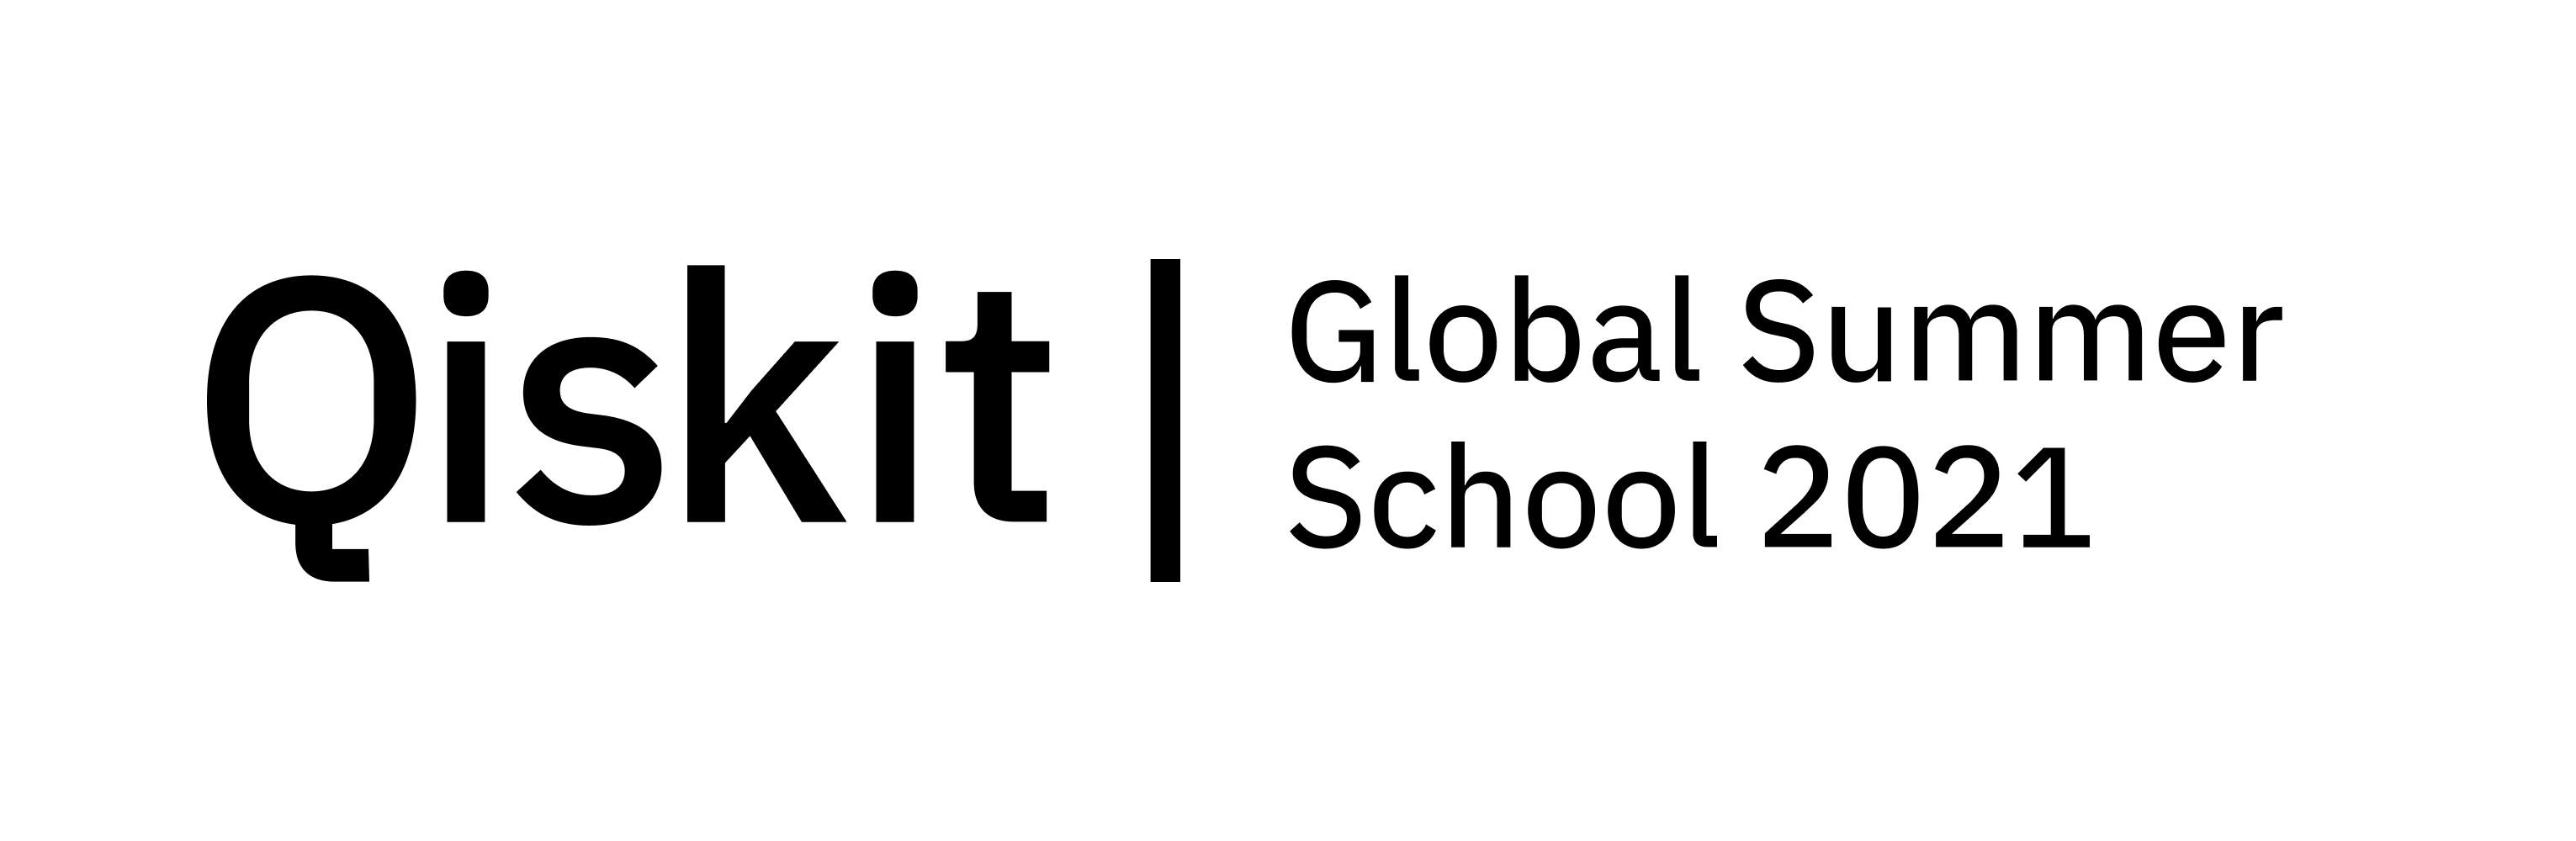</div>

# Lab 2: Introduction to Variational Algorithms

In this Lab, you will learn about
- variational quantum algorithms, in particular Variational Quantum Eigensolvers
- how to create and work with parameterized circuits and quadratic programs in Qiskit
- how to solve optimization problems using QAOA 

In [34]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
mpl.rcParams['figure.dpi'] = 300

## 1) Introduction
This section serves as an introduction to the topic of variational quantum algorithms and as a recap of the material covered in the previous lecture.

### Variational quantum algorithms
In the most general sense, a variational quantum circuit is a circuit that depends on a set of parameters $\theta$. Typically, a variational quantum algorithm queries a quantum computer to sample the output of this parameterized quantum circuit for some fixed parameters and evaluates a given cost function $C(\theta)$ based on this output. A classical optimizer is then used to update the circuit parameters in order to maximize or minimize the objective function $C$. These steps are repeated in a quantum-classical hybrid loop that eventually terminates when the classical optimization has found optimal parameters $\theta^*$.<br>

Variational Quantum Algorithms are often seen as a promising method of achieving quantum advantage on near term devices. In a lot of cases they do not require the execution of deep quantum circuits and systematic errors can partly be mitigated by outsourcing the optimization procedure to a classical optimizer. Nevertheless, VQAs also face a number of challenges, in particular the questions of whether they are efficiently trainable and produce solutions that are in fact superior to those obtained by classical algorithms. 
Despite these challenges, VQAs have been proposed for a variety of problem settings, amongst others the following.

- [Variational Quantum Eigensolvers](https://qiskit.org/textbook/ch-applications/vqe-molecules.html): 
VQEs attempt to approximate the ground state and corresponding energy of a quantum system described by a Hamiltonian $H$ (i.e. the lowest eigenvalue and eigenvector of the corresponding hermitian matrix) (see [below](#variational-quantum-eigensolvers)).

- [QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html): An approximate optimization algorithm used for combinatorial optimization problems. QAOA can be seen as a VQE that solves optimization problems by encoding the cost function as a problem Hamiltonian (see [Section 4](#qaoa)).

- Variational Classifiers: A variational classifier is a quantum circuit that is trained on a data set to classify unseen data samples, reminiscent of classical machine learning classifiers. 

- [Variational Quantum Linear Solvers](https://qiskit.org/textbook/ch-paper-implementations/vqls.html): VQLS solves systems of linear equations by leveraging the basic ideas behind VQEs.



In this lab, we will focus on QAOA as a special case of the Variational Quantum Eigensolver. 

### The Variational Method
Consider a Hermitian operator $H$ describing a quantum system with corresponding ground state $\vert \psi^* \rangle$ and ground state energy $E_0$.
The variational method is a technique to approximate $\vert \psi^* \rangle$ and $E_0$. This is done by choosing a parameterized trial state $\vert \psi(\theta) \rangle$, where $\theta$ denotes a set or vector of parameters. Recall that the energy of the system in the state $\vert \psi \rangle$ is given by its expectation value with respect to $H$
$$
E(\vert \psi \rangle)= \langle \psi \vert H \vert \psi \rangle
$$
Since the ground state of the system is the lowest energy eigenstate, by definition it holds that
$$
E_0 = \langle \psi^* \vert H \vert \psi^* \rangle \leq \langle \psi(\theta) \vert H \vert \psi(\theta) \rangle,
$$
for any parameters $\theta$. Thus, by minimizing the expectation value of the trial state $\psi(\theta)$, that is, finding parameters $\theta$ for which the expectation value $\langle \psi(\theta) \vert H \vert \psi(\theta) \rangle$ becomes as small as possible, we obtain an upper bound on the ground state energy $E_0$ and an approximation of the ground state itself. Naturally, the choice of a good trial state $\psi(\theta)$ is principal to the success of the variational method.

### Variational Quantum Eigensolvers
Variational quantum eigensolvers use the variational method to approximate the ground state and minimal eigenvalue of a Hamiltonian $H$. The trial state now corresponds to a quantum state prepared by a variational quantum circuit and the corresponding expectation value is measured by executing the circuit on a quantum computer. A classical optimizer is then used to tune the circuit parameters and minimize the measured expectation value.<br>

<div>
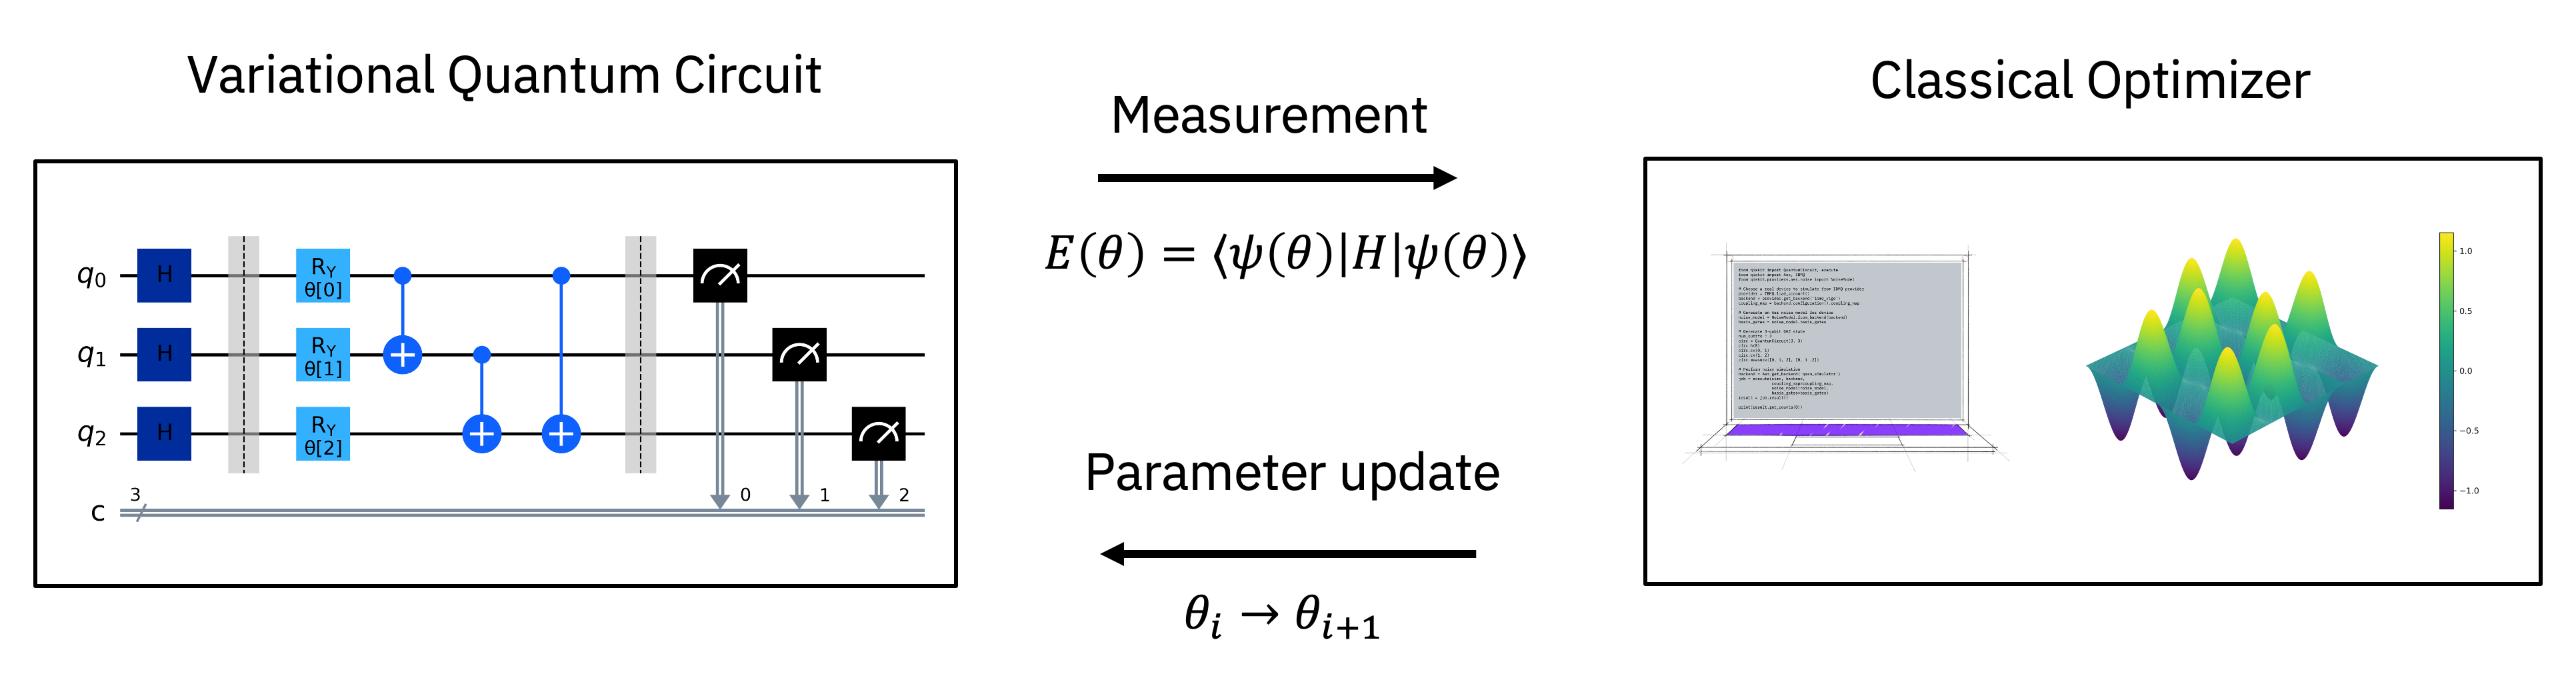
</div>

Apart from being applicable to problems in chemistry or quantum mechanics itself, where we are directly interested in the ground state of a given Hamiltonian, one can also use the concept of variational quantum eigensolvers for optimization problems, by encoding the cost function that should be optimized as a Hamiltonian whose ground state corresponds to the optimal solution of the problem. This idea lies at the heart of QAOA.



## Parameterized Quantum Circuits
In this section, we will learn how to construct parameterized circuits and assign values to circuit parameters in Qiskit, allowing us to build custom variational forms.

### Constructing a parameterized circuit
Creating a quantum circuit with parameters in Qiskit is not much different from creating a standard quantum circuit. We simply initialize parameters using Qiskit's ```Parameter``` class and use them accordingly when appending gates to the constructed circuit. In the following example, we use parameters for the rotation angle of rotational quantum gates.

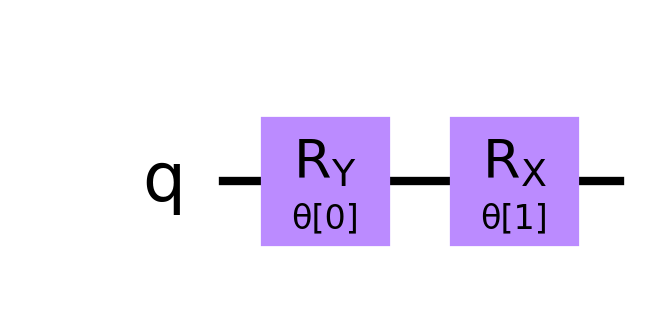

In [35]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List
from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
mpl.rcParams['figure.dpi'] = 300
from qiskit.circuit import Parameter, ParameterVector
#Parameters are initialized with a simple string identifier
parameter_0 = Parameter('θ[0]')
parameter_1 = Parameter('θ[1]')
circuit = QuantumCircuit(1)
#We can then pass the initialized parameters as the rotation angle argument to the Rx and Ry gates
circuit.ry(theta = parameter_0, qubit = 0)
circuit.rx(theta = parameter_1, qubit = 0)
circuit.draw('mpl')


The same parameter can also be used multiple times within the same circuit. Consider the circuit form as above, but with the same parameter used repeatedly for different gates.

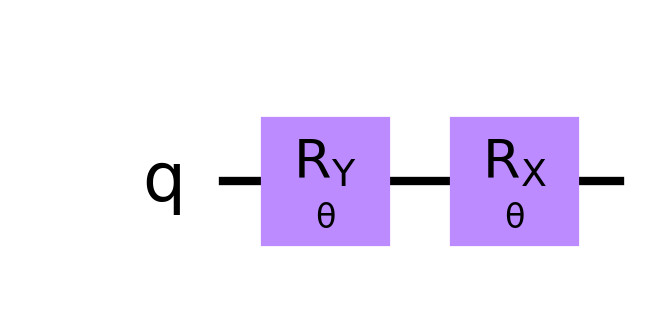

In [36]:
parameter = Parameter('θ')
circuit = QuantumCircuit(1)
circuit.ry(theta = parameter, qubit = 0)
circuit.rx(theta = parameter, qubit = 0)
circuit.draw('mpl')

For convenience, there also exists a ```ParameterVector``` class in Qiskit which allows for the creation of multiple parameters at once. Consider the following example of a RealAmplitudes circuit, which consists of alternating layers of parameterized $R_Y$ gates and entangling $CX$ gates. The [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) variational form is commonly used for classification in quantum machine learning and can also be found in the [circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html) of Qiskit.

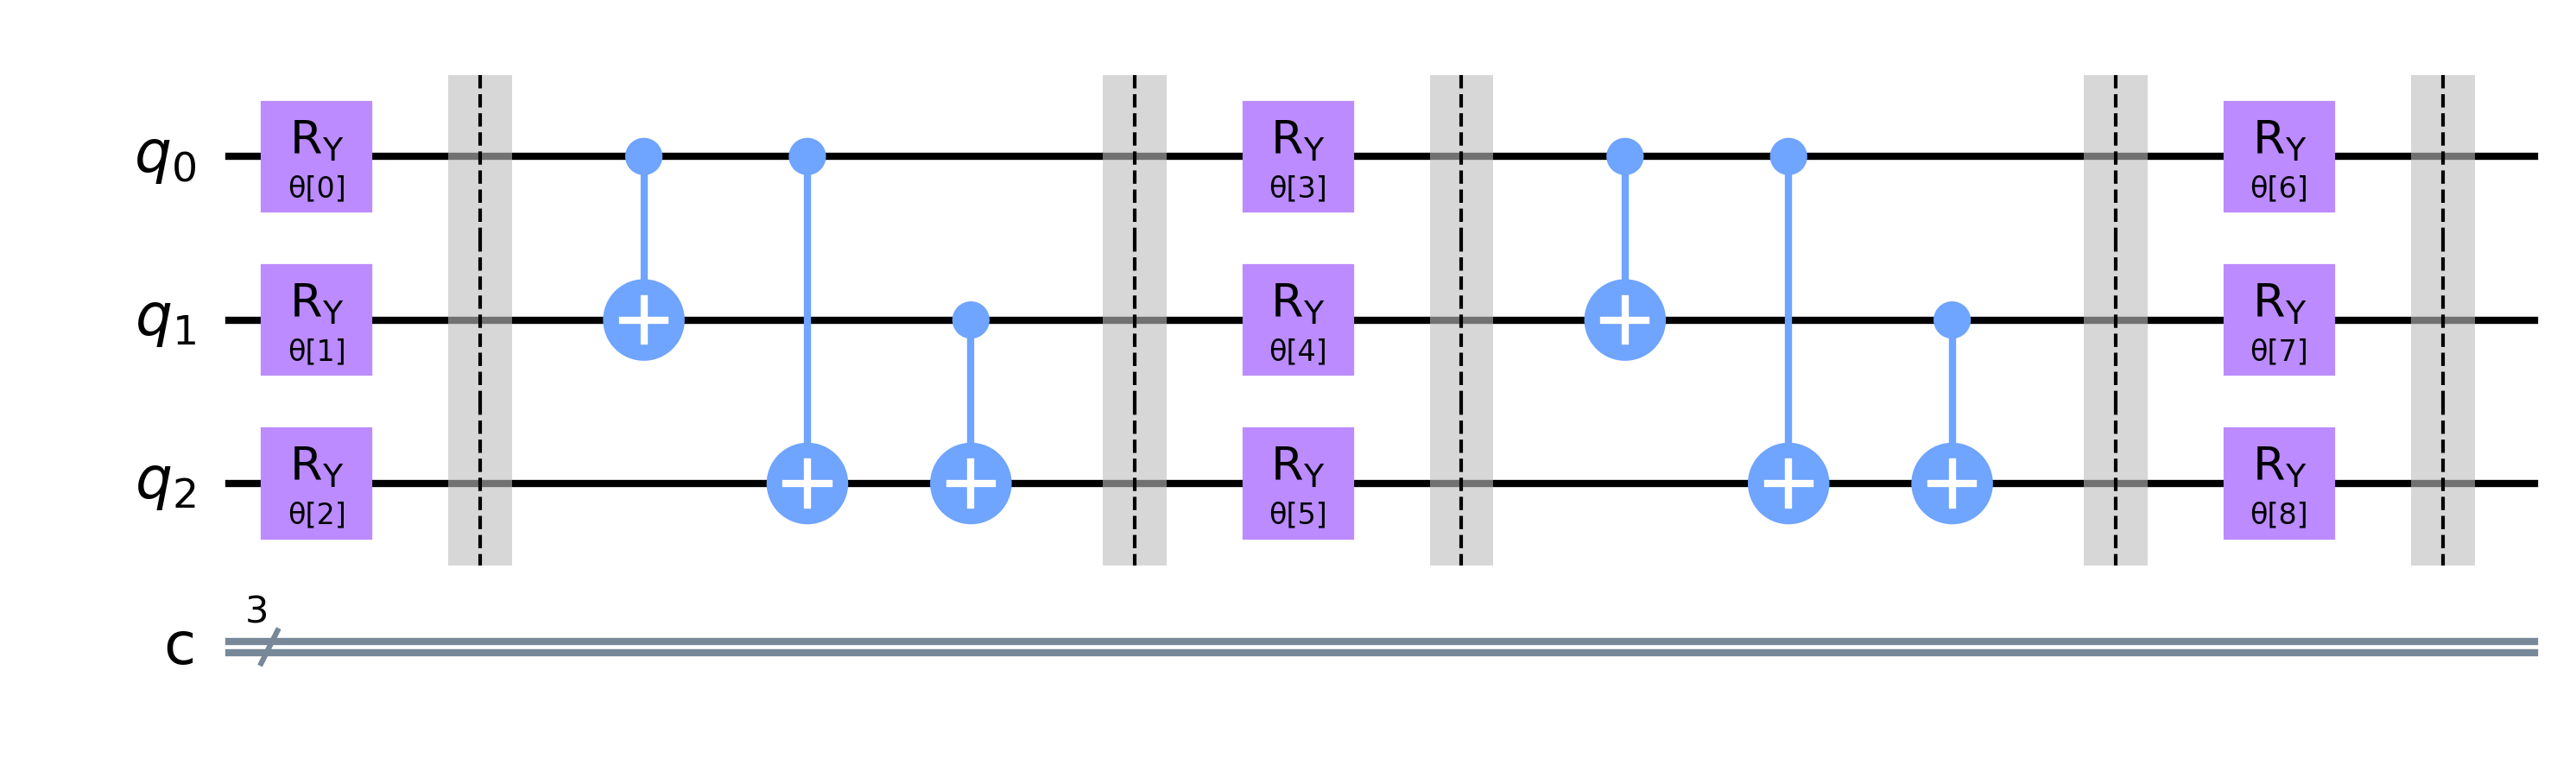

In [37]:
#Set the number of layers and qubits
n=3
num_layers = 2

#ParameterVectors are initialized with a string identifier and an integer specifying the vector length
parameters = ParameterVector('θ', n*(num_layers+1))


circuit = QuantumCircuit(n, n)
for layer in range(num_layers):
    #Appending the parameterized Ry gates using parameters from the vector constructed above
    for i in range(n):
        circuit.ry(parameters[n*layer+i], i)
    circuit.barrier()

    #Appending the entangling CNOT gates
    for i in range(n):
        for j in range(i):
                circuit.cx(j,i)
    circuit.barrier()

#Appending one additional layer of parameterized Ry gates
for i in range(n):
    circuit.ry(parameters[n*num_layers+i], i)
circuit.barrier()

circuit.draw('mpl')

We can inspect the parameters that are part of a quantum circuit.


In [38]:
print(circuit.parameters)

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8])])


### Assigning values to parameters
A parameterized circuit cannot be executed on a quantum backend until the parameters have been assigned fixed values. To do so, we can use the `QuantumCircuit` methods 
```
assign_parameters(parameters, inplace = False)
bind_parameters(values)
```
`bind_parameters` assigns numeric values to the parameters of the circuit, always yielding a new circuit. With `assign_parameters`, one can assign numeric values or substitute parameters by other parameter expressions. Additionally, with `assign_parameters` it is possible to substitute parameters in place instead of yielding a new circuit. The values or parameter expressions that should be assigned to the circuit parameters can be provided either as a dictionary, where the dictionary keys correspond to the parameters in the circuit and the dictionary values are the values to bind, or as an iterable of values. In the latter case values are assigned to parameters in the same order as parameters were added to the circuit.

{ParameterVectorElement(θ[0]): 0.31171107608941095, ParameterVectorElement(θ[1]): 0.5200680211778108, ParameterVectorElement(θ[2]): 0.5467102793432796, ParameterVectorElement(θ[3]): 0.18485445552552704, ParameterVectorElement(θ[4]): 0.9695846277645586, ParameterVectorElement(θ[5]): 0.7751328233611146, ParameterVectorElement(θ[6]): 0.9394989415641891, ParameterVectorElement(θ[7]): 0.8948273504276488, ParameterVectorElement(θ[8]): 0.5978999788110851}


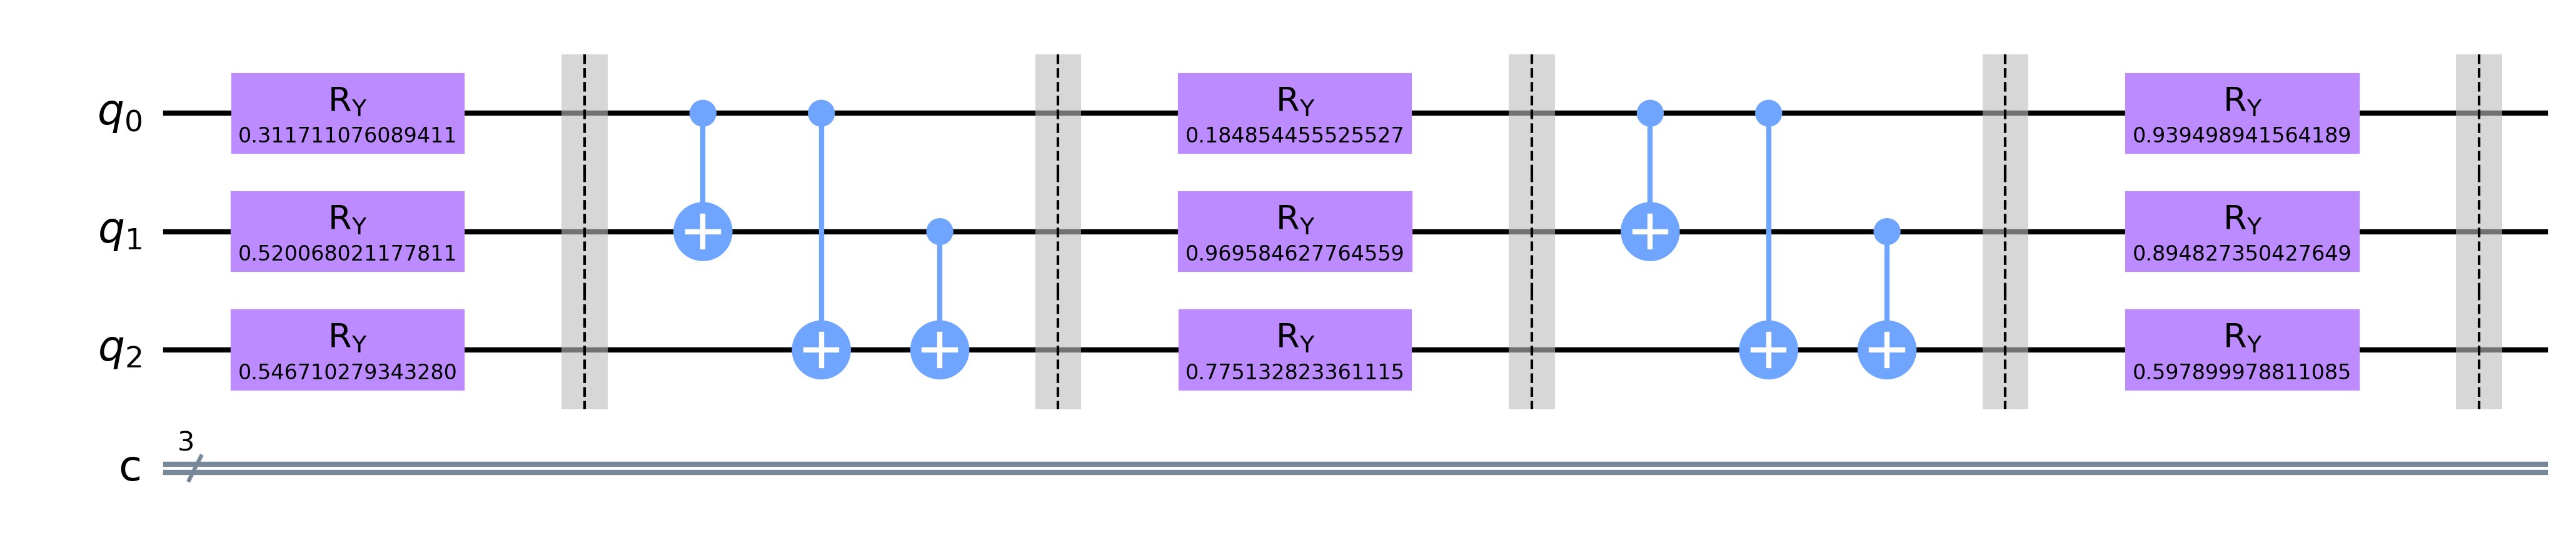

In [39]:
#Create parameter dictionary with random values to bind
param_dict = {parameter: np.random.random() for parameter in parameters}
print(param_dict)
#Assign parameters using the assign_parameters method
bound_circuit = circuit.assign_parameters(parameters = param_dict)
bound_circuit.draw('mpl')

Consider also the following circuit, where we substitute a parameter from the original circuit by another parameter expression.

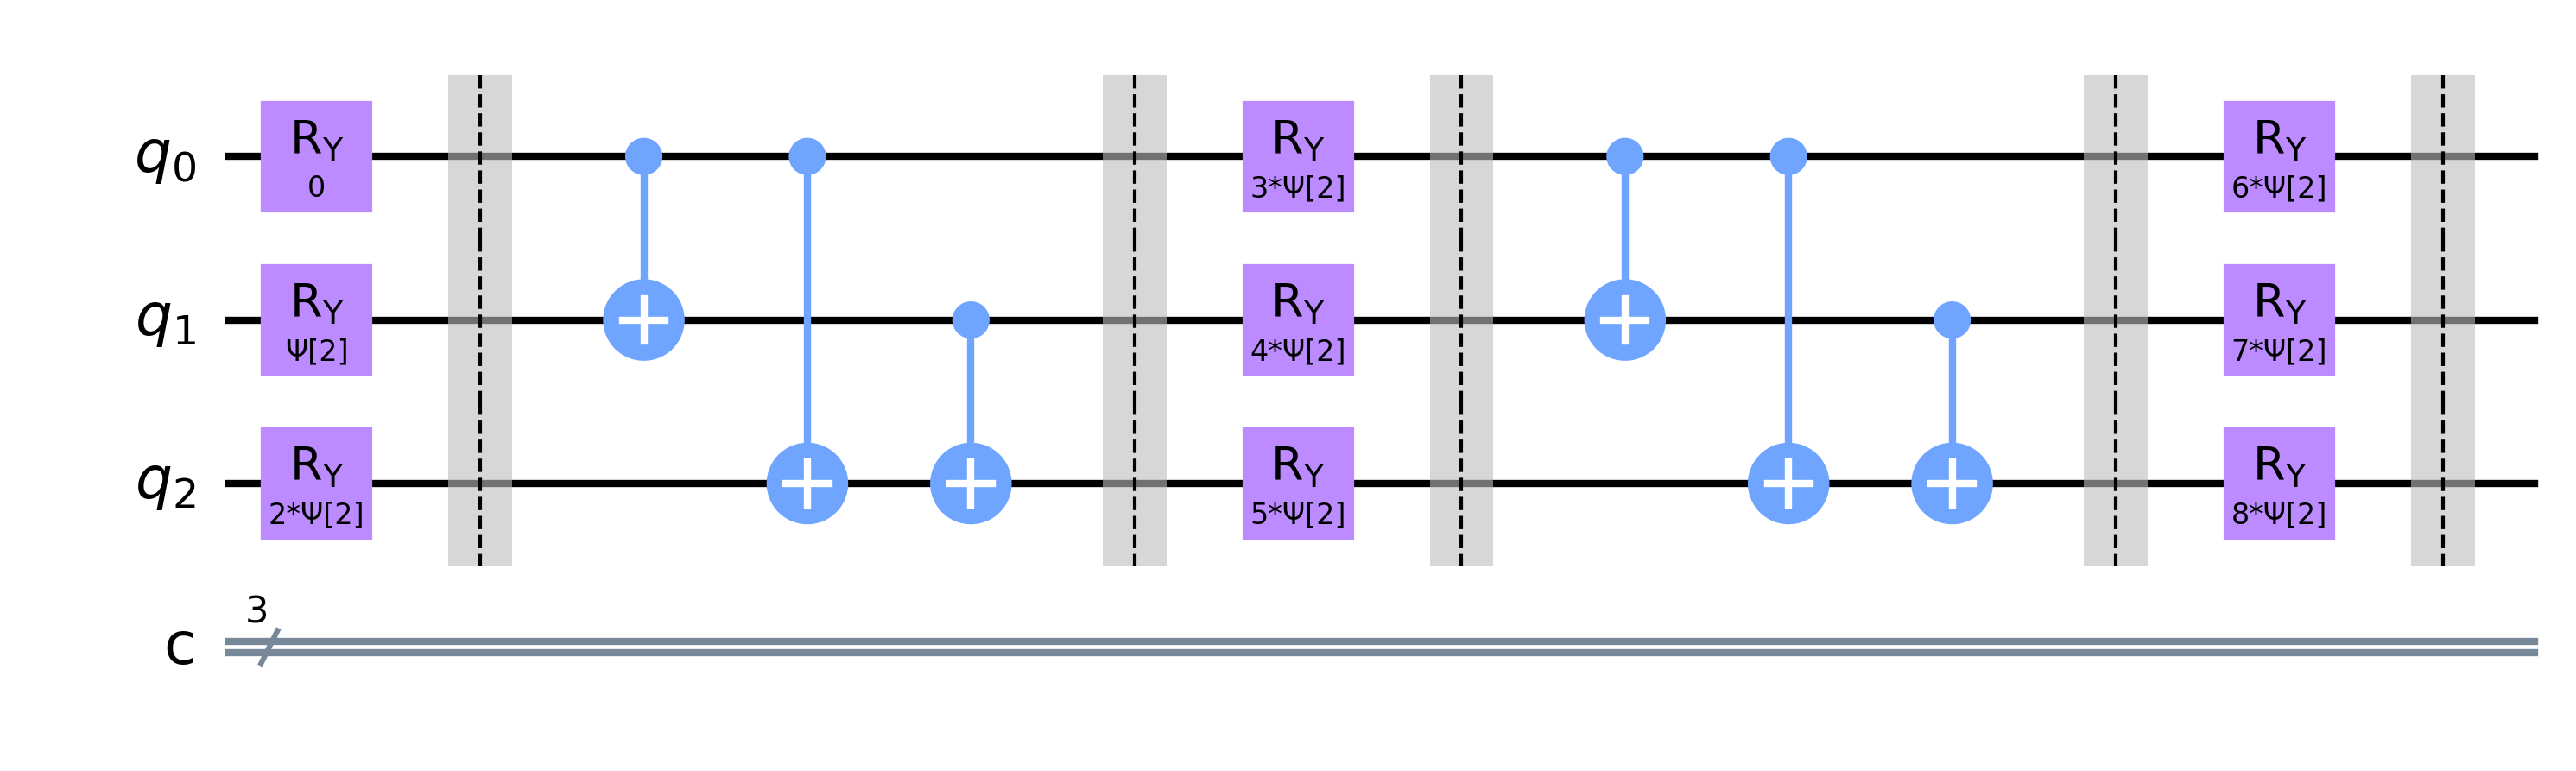

In [40]:
new_parameters = ParameterVector('Ψ',9)
new_circuit = circuit.assign_parameters(parameters = [k*new_parameters[i] for k in range(9)])
new_circuit.draw('mpl')

The bound version of the circuit can now be executed on a quantum device. Attempting to execute a parameterized quantum circuit with non-assigned parameters will throw an error.

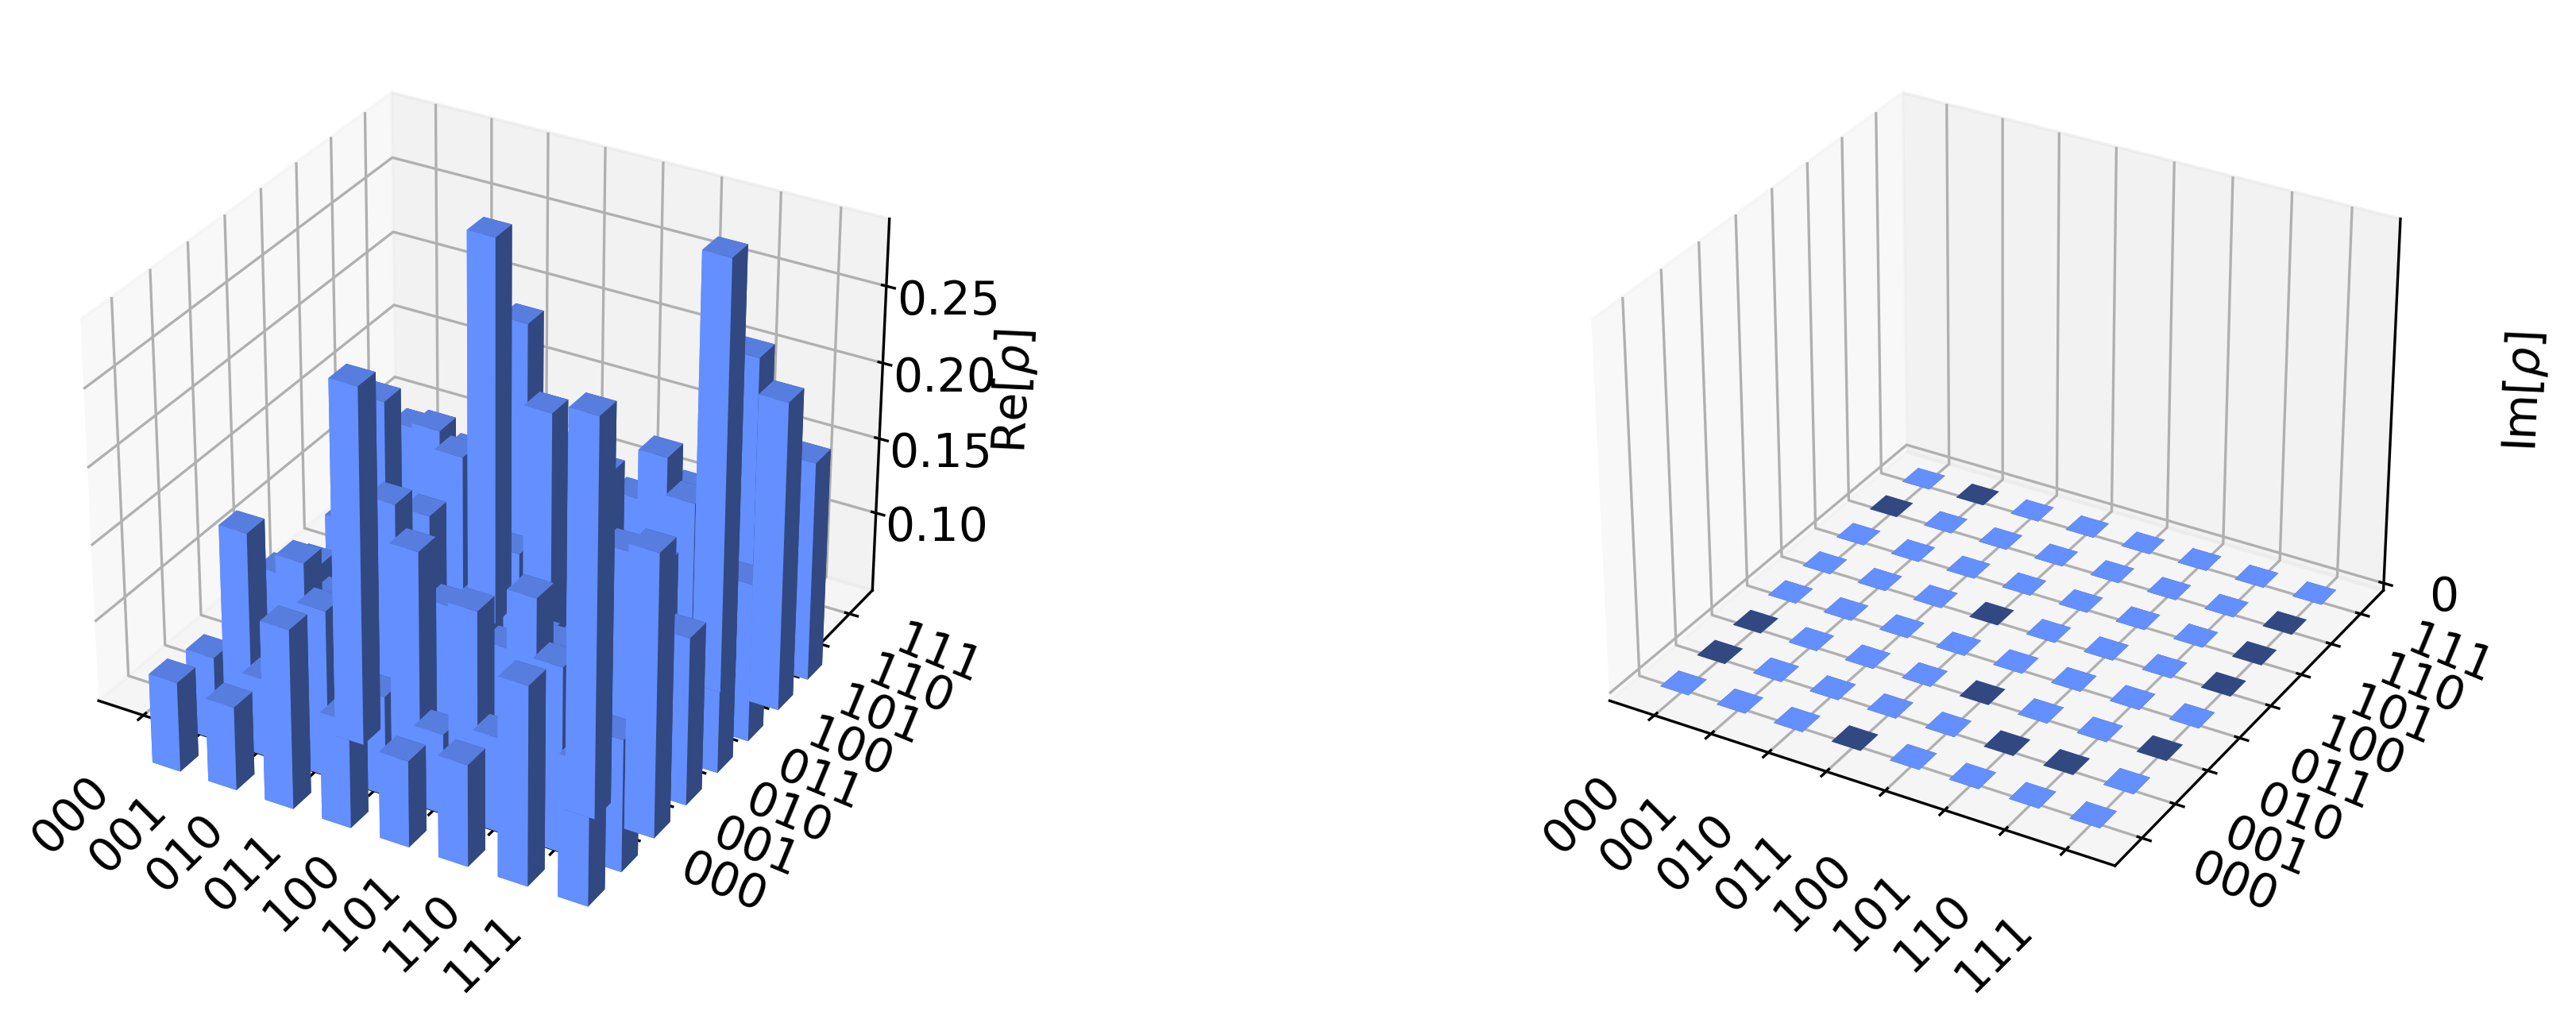

In [41]:
#Run the circuit with assigned parameters on Aer's statevector simulator
simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(bound_circuit).result()
statevector = result.get_statevector(bound_circuit)
plot_state_city(statevector)

In [42]:
#The following line produces an error when run because 'circuit' still contains non-assigned parameters
#result = simulator.run(circuit).result()

## Quadratic Programs
In this section, we will review the MaxCut problem and learn how to construct quadratic programs in Qiskit. 

### MaxCut
In the MaxCut problem, the input is a (possibly weighted) graph and one attempts to find a partition of the graph vertices into two disjoint sets, such that the cumulative weight of edges connecting vertices from different cuts is maximized. <br>

<div>
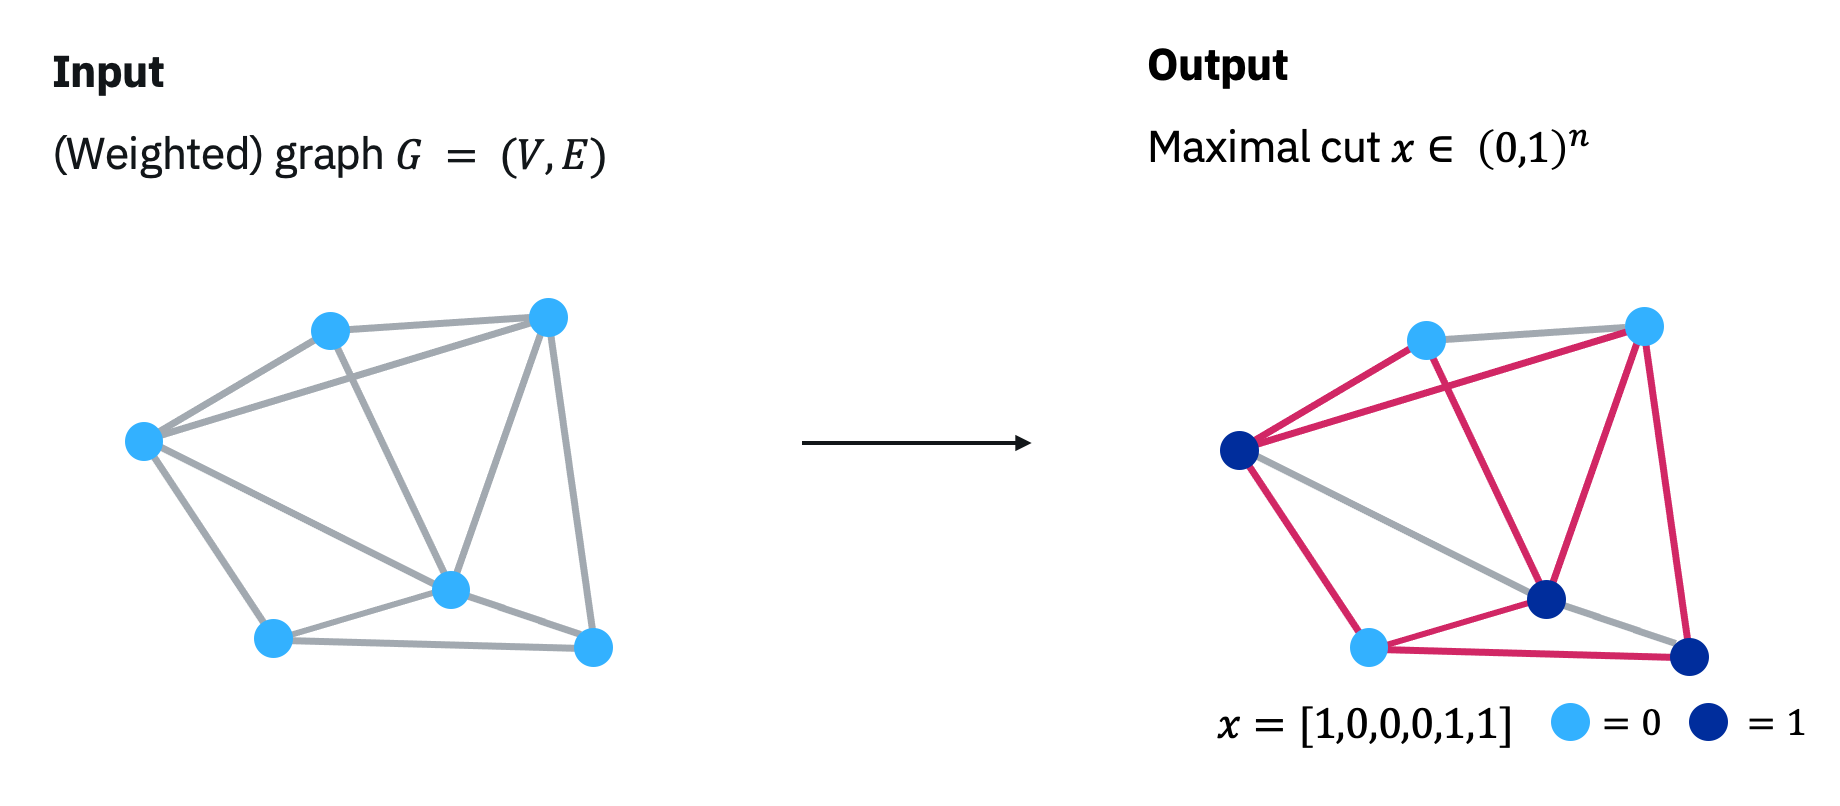
</div>

Let $G=(V,E)$ be a (weighted) graph with $n$ vertices. By numbering the vertices $v_1, \dots, v_n$, and assigning each vertex either the value 0 or 1, we can identify any cut of the graph with a vector $x \in \{0,1\}^n$. The weight of a cut $x$ is then determined by the cost function
$$
C(x) = \sum_{i,j=1}^n W_{ij} x_i (1-x_j)
$$
where $W_{ij} = W_{ji}$ determines the weight of the edge connecting vertices $v_i$ and $v_j$, and $W_{ij} = 0$ if $v_i$ and $v_j$ are not connected by an edge. It is easy to see that each edge weight contributes exactly once to the sum if and only if $x_i \neq x_j$. <br>

The dictionary `graphs` defined below contains a number of different graph instances for you to explore. The name ending for each graph specifies the kinds of weights used.

In [43]:
for key in graphs.keys():
    print(key)

barbell_unweighted
barbell_float(-1_1)
barbell_int(-5_5)
circular_small_unweighted
circular_small_float(-1_1)
circular_small_int(-5_5)
circular_large_unweighted
circular_large_float(-1_1)
circular_large_int(-5_5)
fully_connected_small_unweighted
fully_connected_small_float(-1_1)
fully_connected_small_int(-5_5)
fully_connected_large_unweighted
fully_connected_large_float(-1_1)
fully_connected_large_int(-5_5)
custom


Let us create one more graph instance using the `networkx` module and add it to the dictionary. You can use the widget below to explore cuts of different graph instances. The two groups of vertices are marked in light and dark blue, respectively, and edges that connect vertices from different groups (and therefore contribute to the cut weight) are marked in red.

In [44]:
graph = nx.Graph()
#Add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),(1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
graph.add_weighted_edges_from(edges)
graphs['custom'] = graph
#Display widget
display_maxcut_widget(graphs['custom'])

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

Output()

<div class="alert alert-block alert-success">

<p style="font-size:25px">
Exercise 1: MaxCut
</p>

For the newly defined graph above, find the maximum cut and pass it as a list of bits '$x=$\[$x_0, x_1, ..., x_n$\]' to the grader. You can use the following function which displays a bar plot of the cost function values for all possible bitstrings, but you need to add the code that computes the maxcut cost function value for a particular bitstring $x$. The numpy matrix `weight_matrix` refers to $W$ and you can access its elements $W_{ij}$ via `weight_matrix[i,j]`.

</div>

In [45]:
def maxcut_cost_fn(graph: nx.Graph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    #Get the weight matrix of the graph
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0.

    #INSERT YOUR CODE TO COMPUTE THE CUT VALUE HERE
    for i in range(size):
        for j in range(size):
            value =value +weight_matrix[i,j]*bitstring[i]*(1-bitstring[j])
    return value

def plot_maxcut_histogram(graph: nx.Graph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.number_of_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_fn(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))
    #Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
    fig.show()


In [46]:
plot_maxcut_histogram(graph = graphs['custom'])

In [47]:
from qc_grader import grade_lab2_ex1
bitstring = [1, 0, 1, 1, 0, 0] #DEFINE THE CORRECT MAXCUT BITSTRING HERE

# Note that the grading function is expecting a list of integers '0' and '1'
grade_lab2_ex1(bitstring)

Submitting your answer for lab2/ex1. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Quadratic Programs

A quadratically constrained quadratic program is an optimization problem with a quadratic objective function and linear and quadratic constraints on the optimization variables. In other words, it can be written in the following form
$$
\begin{align}
\text{minimize} &&x^T Q x + c^T x &&\\
&& && \\
\text{subject to} &&Ax \leq b  &&\\
&& x^TQ_ix + a_i^Tx \leq r_i \\
&& l_j \leq x_j \leq u_j \\
\end{align}
$$
where $Q \in \mathbb{R}^{n \times n}$ is a symmetric real-valued $n \times n$-matrix and $c \in \mathbb{R}^n$ is a real-valued vector specifying the quadratic and linear parts of the objective function. The optimization variables $x_i, i \in \{1, \dots, n\}$ can be binary, integer- or real-valued, depending on the problem at hand.

In Qiskit, we can create quadratic programs with the `QuadraticProgram` class, located in the `qiskit_optimization` module. To generate a new model, simply call the initializer with the desired problem name.

In [48]:
from qiskit_optimization import QuadraticProgram
quadratic_program = QuadraticProgram('sample_problem')
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: sample_problem

Minimize
 obj:
Subject To

Bounds
End



We can add binary, integer or continuous optimization variables by calling the respective methods `binary_var`, `integer_var` and `continuous_var`. Any variable added to the quadratic program is specified by a name. We can also specify variable bounds for integer and continuous variables, using the `lowerbound` and `upperbound` arguments.

In [49]:
quadratic_program.binary_var(name = 'x_0')
quadratic_program.integer_var(name = 'x_1')
quadratic_program.continuous_var(name = 'x_2', lowerbound = -2.5, upperbound = 1.8)

To set the objective function, use the methods `minimize` or `maximize`, depending on whether it is a minimization or maximization problem. The quadratic and linear terms can be specified by passing either a list, a matrix or a dictionary for the arguments `linear` and `quadratic`. It is also possible to specify a constant offset with the argument `constant`. <br>

Finally, to print the quadratic program in a readable format, use the method `export_as_lp_string`.

In [50]:
quadratic = [[0,1,2],[3,4,5],[0,1,2]]
linear = [10,20,30]
quadratic_program.minimize(quadratic = quadratic, linear = linear, constant = -5)
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: sample_problem

Minimize
 obj: 10 x_0 + 20 x_1 + 30 x_2 + [ 8 x_0*x_1 + 4 x_0*x_2 + 8 x_1^2 + 12 x_1*x_2
      + 4 x_2^2 ]/2 -5
Subject To

Bounds
 0 <= x_0 <= 1
 -2.500000000000 <= x_2 <= 1.800000000000

Binaries
 x_0

Generals
 x_1
End



Instead of creating quadratic programs from scratch, we can also convert an existing `docplex` model, explained in more detail in this [tutorial](https://qiskit.org/documentation/tutorials/optimization/1_quadratic_program.html) on quadratic programs.

### MaxCut as a Quadratic Program
We can formulate any MaxCut problem as a quadratic program. Consider again the cost function for a MaxCut problem with symmetric weight matrix $W$
$$
C(x) = \sum_{i,j=1}^n W_{ij} x_i (1-x_j).
$$
This is clearly a quadratic cost function and we can reformulate it in the standard form for quadratic programs as written above.
$$
\begin{align}
\sum_{i,j=1}^n W_{ij} x_i (1-x_j) &= \sum_{i,j=1}^n W_{ij} x_i - W_{ij}x_i x_j  \\
&= \sum_{i=1}^n \left( \sum_{j=1}^n W_{ij} \right) x_i - \sum_{i,j = 1}^n W_{ij}x_i x_j \\
&= c^T x + x^T Q x, \\
\end{align}
$$
for $Q$ and $c$ defined as follows
$$
Q_{ij} = -W_{ij} \qquad c_i = \sum_{j=1}^n W_{ij}.
$$
Thus, we obtain an optimization instance with binary variables, a quadratic objective function and without any variable constraints. A quadratic program of that form is also called a quadratic unconstrained binary optimization instance, or QUBO for short. In the next section, we will learn how to use QAOA to optimize problems of that type.

<div class="alert alert-block alert-success">
    
<p style="font-size:25px">
Exercise 2: MaxCut to QUBO 
</p>
    
The following function should construct a quadratic program from a MaxCut problem instance defined by a graph. Complete the code, using the methods explained in the previous section. You will have to add binary variables to the quadratic program which should be named 'x_0', 'x_1', ..., 'x_n'. We refer to the weight matrix $W$ as `weight_matrix` and to the qubo matrix $Q$ as `qubo_matrix`.

</div>

In [51]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    #INSERT YOUR CODE HERE
    quadratic_program = QuadraticProgram('problem')
    print(quadratic_program.export_as_lp_string())
    
    quadratic =qubo_matrix
    
    linear=qubo_vector
    
    for i in range(size):
        quadratic_program.binary_var(name='x_'+str(i))
    quadratic_program.maximize(quadratic = quadratic, linear =linear)
        
    return quadratic_program

In [52]:
quadratic_program = quadratic_program_from_graph(graphs['custom'])
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Minimize
 obj:
Subject To

Bounds
End

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Maximize
 obj: 12 x_0 + 11 x_1 + 12 x_2 + 9 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 8 x_0*x_3 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3
      - 4 x_1*x_4 - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5
      ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [53]:
from qc_grader import grade_lab2_ex2
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    #INSERT YOUR CODE HERE
    quadratic_program = QuadraticProgram('problem')
    print(quadratic_program.export_as_lp_string())
    
    quadratic = qubo_matrix
    
    linear=qubo_vector
    
    for i in range(size):
        quadratic_program.binary_var(name='x_'+str(i))
    quadratic_program.maximize(quadratic = quadratic, linear =linear, constant = -5)
    print(quadratic_program.export_as_lp_string())
    
        
    return quadratic_program
# Note that the grading function is expecting a quadratic program
grade_lab2_ex2(quadratic_program)

Submitting your answer for lab2/ex2. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## QAOA
In this section, we will implement our own version of the QAOA variational form and solve the MaxCut problem defined in the sections above, using the Quantum Approximate Optimization Algorithm (QAOA) implemented in Qiskit. 

### QAOA Variational Form 
Recall that the variational form for QAOA has the following layerized structure <br>

<div>
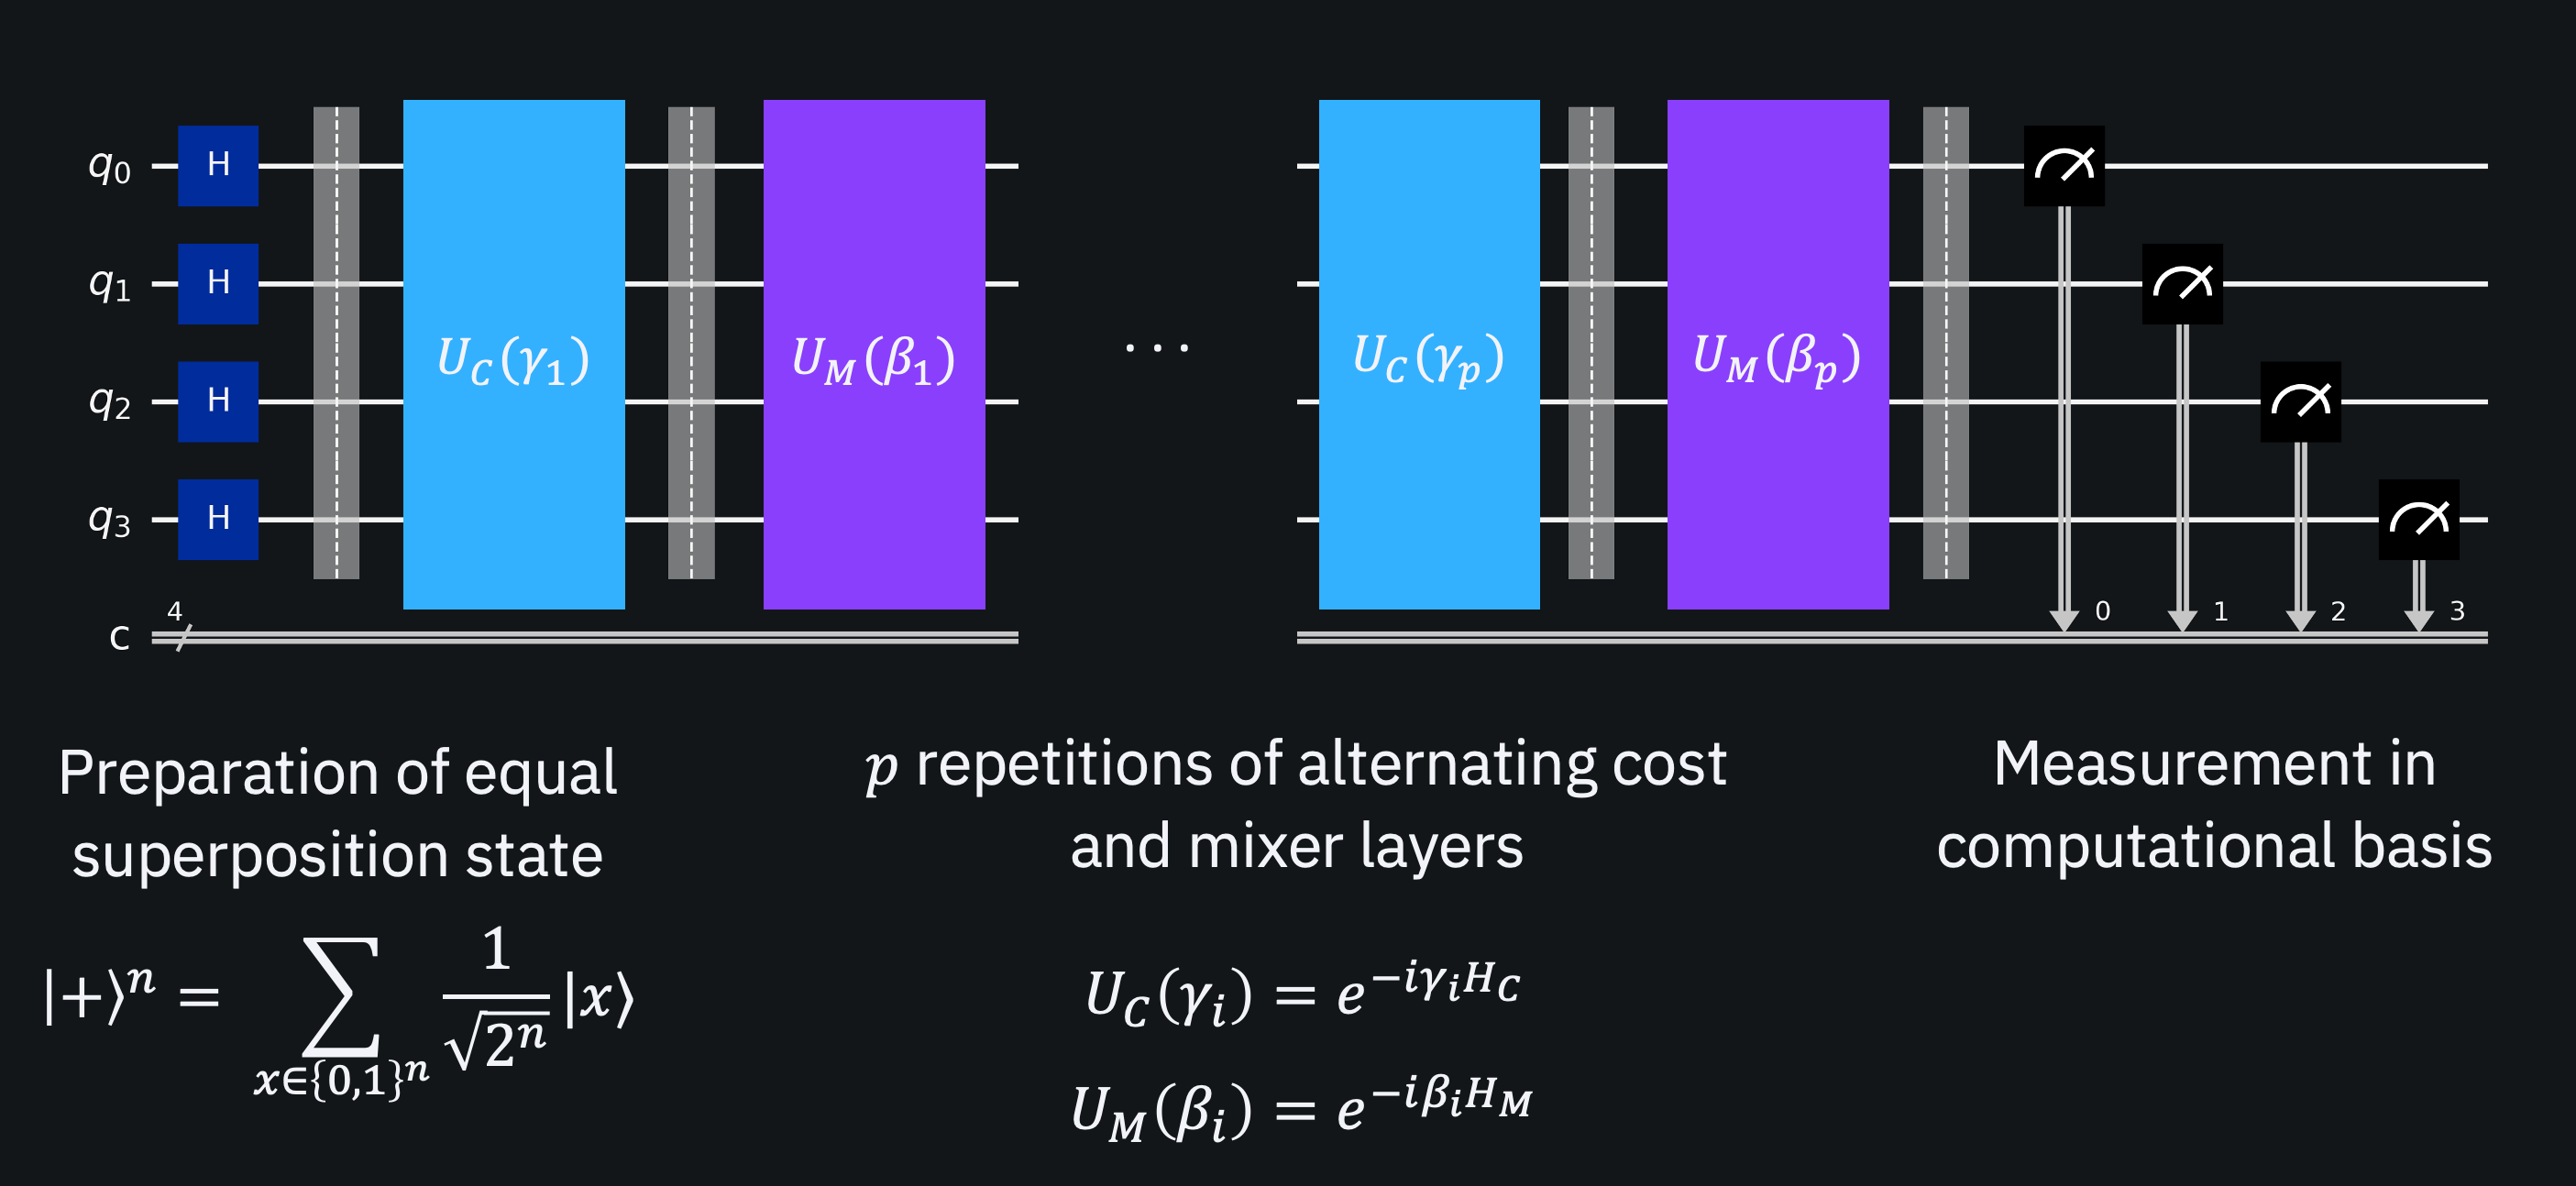
</div>

where $H_C$ refers to a cost Hamiltonian that encodes the cost function of the optimization problem and $H_M$ is a mixer hamiltonian. <br>
In the original version of QAOA, the initial prepared state is the equal superposition state 
$$
\vert + \rangle = \sum_{x \in \{0,1\}^{n}} \frac{1}{\sqrt{2^n}}  \vert x \rangle
$$
and the mixer Hamiltonian is defined as the sum of single Pauli $X$-operators on all qubits
$$
H_M = \sum_{i=1}^n{X_i}.
$$
For a QUBO instance with corresponding matrix $Q$, we would like to encode the cost function $C(x)$ as the cost Hamiltonian $H_C$, that is we are trying to find an operator $H_C$, such that
$$
H_C \vert x \rangle = \left( x^T Q x + c^T x \right) \vert x \rangle = \left( \sum_{i,j=1}^n x_i Q_{ij} x_j + \sum_{i=1}^n c_ix_i \right) \vert x \rangle
$$
for all computational basis states $x \in \{0,1\}^n$.<br>
Using the fact that
$$
Z_i\vert x \rangle = (-1)^{x_i}  \vert x \rangle = \left( 1-2x_i \right) \vert x \rangle \implies x_i \vert x \rangle = \frac{\mathbb{I}-Z_i}{2}\vert x \rangle,
$$
where $\mathbb{I}$ denotes the unit operator and $Z_i$ the Pauli-Z matrix for qubit $i$, we can write $H_C$ as a sum of Pauli-Z operators, by carrying out the substitution $x_i \to  \frac{\mathbb{I}-Z_i}{2}$ in the cost function expression $C(x)$. This yields the following expression for $H_C$
$$
H_C = \sum_{i,j=1}^n \frac{1}{4}Q_{ij} Z_iZ_j - \sum_{i=1}^n \frac{1}{2} \left(c_i + \sum_{j=1}^n Q_{ij} \right) Z_i +  \left( \sum_{i,j=1}^n \frac{Q_{ij}}{4} + \sum_{i=1}^n \frac{c_i}{2} \right)
$$
Exponentiating both Hamiltonians, we obtain a variational from consisting of $R_Z$ and $R_{ZZ}$ gates in the cost layer and $R_X$ gates in the mixer layer
$$
e^{- i \beta H_M} = \prod_{i=1}^n R_{X_i}(2\beta) \quad \quad e^{- i \gamma H_C} = \prod_{i,j=1 \\ i \neq j}^n R_{Z_iZ_j} \left( \frac{1}{2} Q_{ij} \gamma \right) \prod_{i=1}^nR_{Z_i} \left( \left( c_i + \sum_{j=1}^n Q_{ij} \right) \gamma \right)
$$
As an example, consider the QAOA variational form for the QUBO of the MaxCut instance defined above (for $p=1$). <br>

<div>

</div>

The $R_{ZZ}$ gates in the circuit above have been decomposed as a combination of two $CNOT$ gates and one single rotational $R_Z$ gate. Note also that in QAOA circuits for MaxCut QUBO instances, the angle of the single rotational $R_Z$ gates is always equal to 0.

<div class="alert alert-block alert-success">

<p style="font-size:25px">
Exercise 3: QAOA Variational Form
</p>

Write a function that takes as input a quadratic program and a parameter $p$, and produces as output the corresponding QAOA circuit with $p$ layers. The basic construct of the function is provided below, but you will have to insert the parts where the cost and mixer layers are applied. You will need to calculate the angles of the rotational gates as described in the final equations above. In the code below, we refer to the qubo matrix $Q$ as `qubo_matrix`, and to the vector $c$ as `qubo_linearity`. Make sure not to include any measurements in the circuit.

</div>

In [61]:

def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    
           
    for i in range(p):
        for j in range(size):
            matrix_sum = 0
            for k in range(size):
                matrix_sum += qubo_matrix[j, k]
            qaoa_circuit.rz((qubo_linearity[j] + matrix_sum) * gammas[i], j)
            
    
        for j in range(size):
            for k in range(size):
                if j != k:
                    qaoa_circuit.rzz(1/2 * qubo_matrix[j][k] * gammas[i], j, k)
                    
        for j in range(size):
            qaoa_circuit.rx(2*betas[i],j)
    

    return qaoa_circuit




Once you have finished the exercises above, you can explore the QAOA circuits of different graph instances.

In [62]:
quadratic_program = quadratic_program_from_graph(graphs['custom'])
custom_circuit = qaoa_circuit(qubo = quadratic_program)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Minimize
 obj:
Subject To

Bounds
End

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Maximize
 obj: 12 x_0 + 11 x_1 + 12 x_2 + 9 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 8 x_0*x_3 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3
      - 4 x_1*x_4 - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5
      ]/2 -5
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [63]:
test = custom_circuit.assign_parameters(parameters=[1.0]*len(custom_circuit.parameters))

In [65]:
from qc_grader import grade_lab2_ex3
def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    
           
    for i in range(p):
        for j in range(size):
            matrix_sum = 0
            for k in range(size):
                matrix_sum += qubo_matrix[j, k]
            qaoa_circuit.rz((qubo_linearity[j] + matrix_sum) * gammas[i], j)
            
    
        for j in range(size):
            for k in range(size):
                if j != k:
                    qaoa_circuit.rzz(0.5 * qubo_matrix[j][k] * gammas[i], j, k)
                    
        for j in range(size):
            qaoa_circuit.rx(2*betas[i],j)
    
    return qaoa_circuit
# Note that the grading function is expecting a quantum circuit
grade_lab2_ex3(test)

Submitting your answer for lab2/ex3. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### The QAOA and MinimumEigenOptimizer class
If you have managed to complete the previous exercises, congratulations! You have implemented your own version of QAOA that can solve general QUBO instances and in particular MaxCut problems by running on a quantum computer. Qiskit also provides its own implementation of QAOA which allows us to solve optimization problems with only a few lines of code. <br>
The [`QAOA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html) class in Qiskit is located in `qiskit.algorithms` and directly inherits from the Variational Quantum Eigensolver class [`VQE`](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html). The initializer for `QAOA` takes the following input parameters, amongst others
- `optimizer`: This argument refers to the classical optimizer used for updating the circuit parameters. Qiskit offers a number of different [optimizers](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html) and you can also define your own by subclassing Qiskit's native [`Optimizer`](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.Optimizer.html#qiskit.aqua.components.optimizers.Optimizer) class. Some of the basic optimizers offered by Qiskit are the following: <br>
    - [COBYLA](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.COBYLA.html#qiskit.aqua.components.optimizers.COBYLA): Constrained Optimization By Linear Approximation optimizer.
    - [SLSQP](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.SLSQP.html#qiskit.aqua.components.optimizers.SLSQP): Sequential Least SQuares Programming optimizer.
    - [ADAM](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.ADAM.html#qiskit.aqua.components.optimizers.ADAM):  A gradient-based optimization algorithm that is relies on adaptive estimates of lower-order moments.
- `reps`: The number of layers $p$ in the QAOA variational form, i.e. the depth of the algorithm. For higher values of $p$, QAOA can theoretically obtain better results but the quantum circuit becomes deeper and there are more parameters to optimize.
- `initial_point`: Optional initial parameter values (values for $\beta$ and $\gamma$) to start the optimization with.
- `quantum_instance`: The quantum instance to run the algorithm on. This can be a simulator or a real hardware device.
- `callback`: A callback function that can be used to monitor the optimization process.

Below, you will be able to test the effect of some of these arguments on the optimization procedure of QAOA.

The [`MinimumEigenOptimizer`](https://qiskit.org/documentation/tutorials/optimization/3_minimum_eigen_optimizer.html) object provides a wrapper for the optimization process that handles the conversion from a quadratic program to a qubit operator as well as calling a given [`MinimumEigenSolver`](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.MinimumEigensolver.html), such as QAOA to obtain the corresponding optimization result. The initializer takes as input the `MinimumEigenSolver` to use for the optimization, and the optimization is run by calling the `optimize` method with a quadratic program as input. Putting it all together, we can obtain a solution for the MaxCut problem defined above with only a couple of lines of code.

In [ ]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
backend = Aer.get_backend('statevector_simulator')
qaoa = QAOA(optimizer = ADAM(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
quadratic_program = quadratic_program_from_graph(graphs['custom'])
result = eigen_optimizer.solve(quadratic_program)
print(result)


As you can see, the optimizer indeed manages to find the optimum within only a few optimization steps. We can also plot the optimized statevector to see which bitstrings are more likely to be sampled after optimization of the parameters has concluded.

In [66]:
def plot_samples(samples):
    """
    Plots a bar diagram for the samples of a quantum algorithm
    Args:
        samples
    """
    #Sort samples by probability
    samples = sorted(samples, key = lambda x: x.probability)
    #Get list of probabilities, function values and bitstrings
    probabilities = [sample.probability for sample in samples]
    values = [sample.fval for sample in samples]
    bitstrings = [''.join([str(int(i)) for i in sample.x]) for sample in samples]
    #Plot bar diagram
    sample_plot = go.Bar(x = bitstrings, y = probabilities, marker=dict(color=values, colorscale = 'plasma',colorbar=dict(title='Function Value')))
    fig = go.Figure(
        data=sample_plot, 
        layout = dict(
            xaxis=dict(
                type = 'category'
            )
        )
    )
    fig.show()

plot_samples(result.samples)

Traceback (most recent call last):
  File "<ipython-input-66-7ef2a8ea0c3e>", line 25, in <module>
    plot_samples(result.samples)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/result/result.py", line 110, in __getattr__
    raise AttributeError(f'Attribute {name} is not defined') from ex
AttributeError: Attribute samples is not defined

Use %tb to get the full traceback.



### Explore: The QAOA Optimization Process 

The following widget shows a precomputed energy landscape for the MaxCut problem defined above and visualizes the QAOA optimization process at depth $p=1$, showing how the statevector and average function value change with each parameter update. Try using different classical optimizers and initial points to see how it affects the optimization process. Note that the first value in `initial_point` sets the initial value for the $\gamma$ parameter and the second value sets the initial value for the $\beta$ parameter.

In [67]:
graph_name = 'custom'
quadratic_program = quadratic_program_from_graph(graph=graphs[graph_name])

trajectory={'beta_0':[], 'gamma_0':[], 'energy':[]}
offset = 1/4*quadratic_program.objective.quadratic.to_array(symmetric  = True).sum() + 1/2*quadratic_program.objective.linear.to_array().sum()
def callback(eval_count, params, mean, std_dev):
    trajectory['beta_0'].append(params[1])
    trajectory['gamma_0'].append(params[0])
    trajectory['energy'].append(-mean + offset)

optimizers = {
    'cobyla': COBYLA(),
    'slsqp': SLSQP(),
    'adam': ADAM()
}
qaoa = QAOA(optimizer = optimizers['cobyla'], quantum_instance = backend, reps=1, initial_point = [6.2,1.8],callback = callback)
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
result = eigen_optimizer.solve(quadratic_program)
fig = QAOA_widget(landscape_file=f'./resources/energy_landscapes/{graph_name}.csv', trajectory = trajectory, samples = result.samples)
fig.show()


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Minimize
 obj:
Subject To

Bounds
End

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Maximize
 obj: 12 x_0 + 11 x_1 + 12 x_2 + 9 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 8 x_0*x_3 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3
      - 4 x_1*x_4 - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5
      ]/2 -5
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End

Traceback (most recent call last):
  File "<ipython-input-67-da42465e1681>", line 16, in <module>
    qaoa = QAOA(optimizer = optimizers['cobyla'], quantum_instance = backend, reps=1, initial_point = [6.2,1.8],callback = callback)
NameError: name 'QAOA' is not defined

Use %tb to get the full traceback.


Observe the periodicity in the cost function landscape plotted above. This is a direct consequence of the periodicity of the rotational gates used in the QAOA variational form. Since all rotational gates have a periodicity of $2\pi$ and the MaxCut example we investigate here only has edges with integer weights, we observe a periodicity of $2 \pi$ in the $\gamma$ parameter and a periodicity of $\pi$ in the $\beta$ parameter.

### Higher values of $p$

With higher values of $p$, QAOA is theoretically able to reach a quantum state with a better energy value with respect to the cost Hamiltonian since increasing the number of layers strictly increases the space of quantum states, one is able to reach. That is, if 
$$
M_p = \max_{\beta, \gamma \in \mathbb{R}^p} \langle \psi_p(\beta, \gamma) \vert H_C  \vert \psi_p(\beta, \gamma) \rangle
$$
denotes the maximal energy value reachable with a QAOA variational form of depth $p$, it holds that
$$
M_{p+1} \geq M_p.
$$
In fact, using the adiabatic theorem, one can prove, that in the infinite limit, we are able to reach the maximal cost function value $C_{max}$
$$
\lim\limits_{p \to \inf} M_p = C_{max}.
$$
While the connection to adiabatic quantum computing serves as a justification of why we might expect QAOA to yield good optimization results, it only holds in the infinite limit, which in turn corresponds to an infinitely long quantum algorithm.
One also needs to be mindful of the fact that the number of parameters increases with the number of layers, and finding the global optimum becomes increasingly harder when introducing more parameters.<br>
The following plots show the evolution of the optimal QAOA state found for increasing values of $p$ and give some idea of how the circuit depth affects QAOA performance.

In [ ]:

graph_name = 'custom'
quadratic_program = quadratic_program_from_graph(graphs[graph_name])
#Create callback to record total number of evaluations
max_evals = 0
def callback(eval_count, params, mean, std_dev):
    global max_evals
    max_evals = eval_count

#Create empty lists to track values
energies = []
runtimes = []
num_evals=[]
    
#Run QAOA for different values of p
for p in range(1,10):
    print(f'Evaluating for p = {p}...')
    qaoa = QAOA(optimizer = optimizers['cobyla'], quantum_instance = backend, reps=p, callback=callback)
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
    start = time()
    result = eigen_optimizer.solve(quadratic_program)
    runtimes.append(time()-start)
    num_evals.append(max_evals)
    #Calculate energy of final state from samples
    avg_value = 0.
    for sample in result.samples:
        avg_value += sample.probability*sample.fval
    energies.append(avg_value)

#Create and display plots
energy_plot = go.Scatter(x = list(range(1,10)), y =energies, marker=dict(color=energies, colorscale = 'plasma'))
runtime_plot = go.Scatter(x = list(range(1,10)), y =runtimes, marker=dict(color=runtimes, colorscale = 'plasma'))
num_evals_plot = go.Scatter(x = list(range(1,10)), y =num_evals, marker=dict(color=num_evals, colorscale = 'plasma'))
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ['Energy value', 'Runtime', 'Number of evaluations'])
fig.update_layout(width=1800,height=600, showlegend=False)
fig.add_trace(energy_plot, row=1, col=1)
fig.add_trace(runtime_plot, row=1, col=2)
fig.add_trace(num_evals_plot, row=1, col=3)
clear_output()
fig.show()

### CVaR
One recently proposed adaptation to QAOA is the idea of calculating the Conditional Value at Risk (or CVaR). Here, instead of calculating the mean of all cut values $c_i$ obtained from the measurement outcomes of the circuit to compute the cost function $f$, the algorithm only takes into account a fraction $\alpha$ of the highest measured cut values.
$$
f(\theta) = \frac{1}{n}\sum_{i=1}^n c_i \to f(\theta) = \frac{1}{\lceil \alpha n \rceil}\sum_{i=1}^{\lceil \alpha n \rceil} c_i,
$$
where the $c_i$ are ordered decreasing in size.
Since we are only interested in obtaining a single good solution for the original optimization problem, looking only at a fraction of the best cuts can help to speed up the optimization process. Let us explore how adding CVaR can change the energy landscape of a QAOA instance. The following code creates and plots a QAOA energy landscape of a given MaxCut instance using your code from the previous exercises and returns the optimal parameters obtained during a grid search. Calculating the energy landscape might take a while.


In [68]:
def plot_qaoa_energy_landscape(graph: nx.Graph, cvar: float = None):
    num_shots = 1000
    seed = 42
    simulator = Aer.get_backend('qasm_simulator')
    simulator.set_options(seed_simulator = 42)

    #Generate circuit
    circuit = qaoa_circuit(qubo = quadratic_program_from_graph(graph), p=1)
    circuit.measure(range(graph.number_of_nodes()),range(graph.number_of_nodes()))

    #Create dictionary with precomputed cut values for all bitstrings 
    cut_values = {}
    size = graph.number_of_nodes()
    for i in range(2**size):
        bitstr = '{:b}'.format(i).rjust(size, '0')[::-1]
        x = [int(bit) for bit in bitstr]
        cut_values[bitstr] = maxcut_cost_fn(graph, x)

    #Perform grid search over all parameters
    data_points = []
    max_energy = None
    for beta in np.linspace(0,np.pi, 50):
        for gamma in np.linspace(0, 4*np.pi, 50):
            bound_circuit = circuit.assign_parameters([beta, gamma])
            result = simulator.run(bound_circuit, shots = num_shots).result()
            statevector = result.get_counts(bound_circuit)
            energy = 0
            measured_cuts = []
            for bitstring, count in statevector.items():
                measured_cuts =  measured_cuts + [cut_values[bitstring]]*count

            if cvar is None:
                #Calculate the mean of all cut values
                energy = sum(measured_cuts)/num_shots
            else:
                raise NotImplementedError()
                #INSERT YOUR CODE HERE

            #Update optimal parameters
            if max_energy is None or energy > max_energy:
                max_energy = energy
                optimum = {'beta': beta, 'gamma': gamma, 'energy': energy}

            #Update data
            data_points.append({'beta': beta, 'gamma': gamma, 'energy': energy})


    #Create and display surface plot from data_points
    df = pd.DataFrame(data_points)
    df = df.pivot(index='beta', columns='gamma', values='energy')
    matrix = df.to_numpy()
    beta_values = df.index.tolist()
    gamma_values = df.columns.tolist()

    surface_plot = go.Surface(
        x=gamma_values, 
        y=beta_values,
        z=matrix,
        coloraxis = 'coloraxis'
    )
    fig = go.Figure(data = surface_plot)
    fig.show()

    #Return optimum
    return optimum



In [69]:
graph = graphs['custom']
optimal_parameters = plot_qaoa_energy_landscape(graph = graph)
print('Optimal parameters:')
print(optimal_parameters)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Minimize
 obj:
Subject To

Bounds
End

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: problem

Maximize
 obj: 12 x_0 + 11 x_1 + 12 x_2 + 9 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 8 x_0*x_3 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3
      - 4 x_1*x_4 - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5
      ]/2 -5
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



Optimal parameters:
{'beta': 0.32057067893773394, 'gamma': 6.411413578754679, 'energy': 19.392}


<div class="alert alert-block alert-success">

<p style="font-size:25px">
Exercise 4: CVaR
</p>

Adapt the code above, so instead of taking the mean of all sampled cut values, the algorithm calculates the conditional value at risk and observe how different settings of the parameter $\alpha$ change the QAOA energy landscape. What are the energy and optimal parameters we obtain by the grid search when setting the CVaR parameter to $\alpha = 0.2$ when using 1000 shots and setting the random seed of the qasm simulator to 42 (as is already done in the code above)?
</div>

In [ ]:
optimal_parameters = plot_qaoa_energy_landscape(graph = graph, cvar = 0.2)
print(optimal_parameters)

In [ ]:
from qc_grader import grade_lab2_ex4

# Note that the grading function is expecting a python dictionary
# with the entries 'beta', 'gamma' and 'energy'
grade_lab2_ex4(optimal_parameters)

## Additional Resources

- [Tutorial on VQEs](https://qiskit.org/textbook/ch-applications/vqe-molecules.html) in Qiskit Textbook
- [Tutorial on combinatorial optimization with QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html) in Qiskit Textbook
- E. Farhi, J. Goldstone, and S. Gutmann, [A Quantum Approximate Optimization Algorithm (2014)](https://arxiv.org/abs/1411.4028): The original QAOA paper 
- [Qiskit Optimization Tutorials](https://qiskit.org/documentation/tutorials/optimization/index.html) including
    - [Quadratic Programs](https://qiskit.org/documentation/tutorials/optimization/1_quadratic_program.html)
    - [Quadratic Program Converters](https://qiskit.org/documentation/tutorials/optimization/2_converters_for_quadratic_programs.html)
    - [Minimum Eigen Optimizer](https://qiskit.org/documentation/tutorials/optimization/3_minimum_eigen_optimizer.html)
- Talk by E. Farhi on [recent results for QAOA](https://www.youtube.com/watch?v=8GnRRxlZuZo) at the Simons Institute for the Theory of Computing
